In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


## Load Directory

In [38]:
train_dir = "../input/fer2013/train" # Directory containing the training data
test_dir = "../input/fer2013/test"  # Directory containing the validation data

## Split to Train and Test (No Validation) [ 80% - 20% ]

In [39]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=(224, 224),        # 🔁 updated from 48x48
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    '/kaggle/input/fer2013/test',
    target_size=(224, 224),        # 🔁 updated here too
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


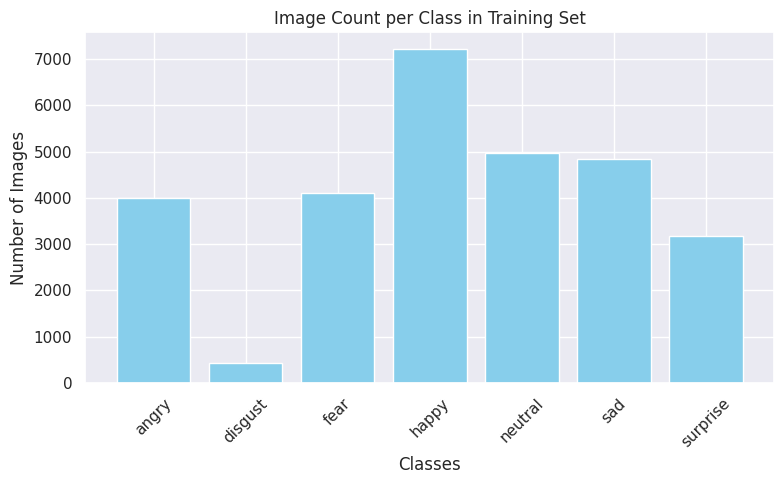

In [40]:
# Get class names and sample counts from the generator
class_names = list(train_generator.class_indices.keys())
class_counts = [0] * len(class_names)

# Count images per class
for i in range(len(train_generator)):
    _, labels = train_generator[i]
    class_indices = np.argmax(labels, axis=1)
    for idx in class_indices:
        class_counts[idx] += 1

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Image Count per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1 Sample image drom the Dataset

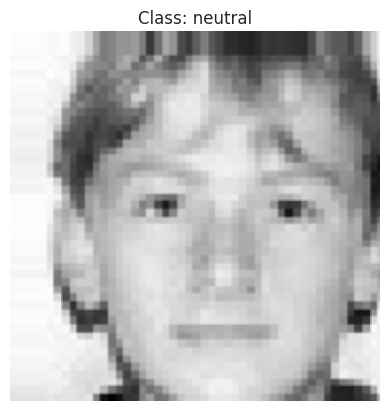

In [41]:
sample_img, sample_label = train_generator[0]
plt.imshow(sample_img[0].squeeze(), cmap='gray')  # .squeeze() for grayscale
plt.title(f"Class: {class_names[np.argmax(sample_label[0])]}")
plt.axis('off')
plt.show()


# Model Network (ResInceptionNet)

In [42]:
def residual_block(x, filters, downsample=False):
    shortcut = x
    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def inception_block(x, f1, f3_in, f3, f5_in, f5, pool_proj):
    path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    path2 = layers.Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

    path3 = layers.Conv2D(f5_in, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=1, padding='same')(x)
    path4 = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(path4)

    return layers.Concatenate()([path1, path2, path3, path4])

def build_deep_hybrid_model(input_shape=(224, 224, 1), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv and Pool
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Alternating Residual + Inception Blocks
    filter_sizes = [64, 128, 128, 256, 256]
    for f in filter_sizes:
        x = residual_block(x, f, downsample=True)
        x = inception_block(x, f, f//2, f, f//4, f//2, f//2)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Example: Build and compile
model = build_deep_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 112, 112, 64)   │          3,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 112, 112, 64)   │            256 │ conv2d_46[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 56, 56, 64)     │              0 │ re_lu_11[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 28, 28, 64)     │         36,928 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 28, 28, 64)     │            256 │ conv2d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_12 (ReLU)           │ (None, 28, 28, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 28, 28, 64)     │         36,928 │ re_lu_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 28, 28, 64)     │          4,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 28, 28, 64)     │            256 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 28, 28, 64)     │            256 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 28, 28, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_13 (ReLU)           │ (None, 28, 28, 64)     │              0 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 28, 28, 32)     │          2,080 │ re_lu_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 28, 28, 16)     │          1,040 │ re_lu_13[0][0]         │
├──────────────────────

 Total params: 7,446,135 (28.40 MB)

 Trainable params: 7,439,479 (28.38 MB)

 Non-trainable params: 6,656 (26.00 KB)

# Training

In [43]:
# === COMPUTE CLASS WEIGHTS ===
labels = np.concatenate([train_generator[i][1] for i in range(len(train_generator))])
class_indices = np.argmax(labels, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)
class_weight_dict = dict(enumerate(class_weights))

# === CALLBACKS ===
checkpoint_callback = ModelCheckpoint(
    filepath='custom_hybrid_model.weights.h5',  # ✅ Updated extension
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

# === TRAIN MODEL ===
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1478 - loss: 2.9729
Epoch 1: val_accuracy improved from -inf to 0.17944, saving model to custom_hybrid_model.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 192s 168ms/step - accuracy: 0.1478 - loss: 2.9726 - val_accuracy: 0.1794 - val_loss: 1.9456 - learning_rate: 1.0000e-04
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss

897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1588 - loss: 2.5359
Epoch 3: val_accuracy improved from 0.17944 to 0.20256, saving model to custom_hybrid_model.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 128s 141ms/step - accuracy: 0.1588 - loss: 2.5358 - val_accuracy: 0.2026 - val_loss: 1.9280 - learning_rate: 1.0000e-04
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1671 - loss: 2.4106
Epoch 5: val_accuracy improved from 0.20256 to 0.24436, saving model to custom_hybrid_model.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 130s 144ms/step - accuracy: 0.1671 - loss: 2.4104 - val_accuracy: 0.2444 - val_loss: 1.9664 - learning_rate: 1.0000e-04
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1952 - loss: 

# Training v/s Testing Loss x Epoch Plot

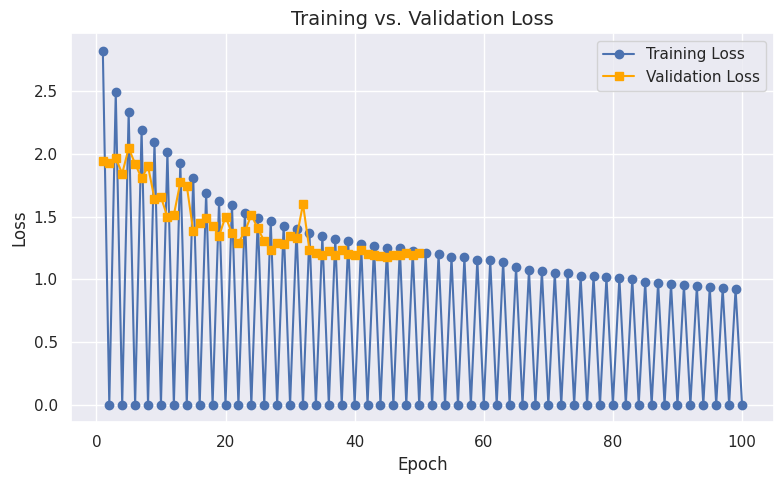

In [44]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Separate epoch ranges
train_epochs = range(1, len(train_loss) + 1)
val_epochs = range(1, len(val_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_loss, 'o-', label='Training Loss')
plt.plot(val_epochs, val_loss, 's-', label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Training v/s Testing Accuracy x Epoch Plot

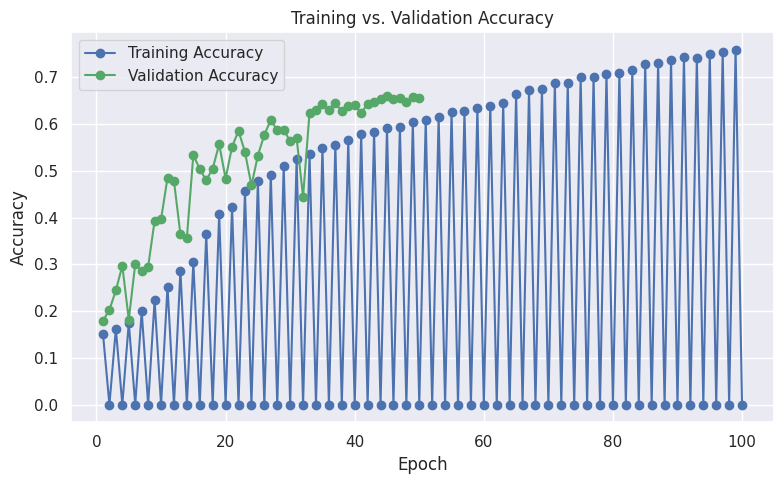

In [45]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])

# Define epochs based on lengths
train_epochs = range(1, len(train_acc) + 1)
val_epochs = range(1, len(val_acc) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(val_epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Confusion Matrix

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step


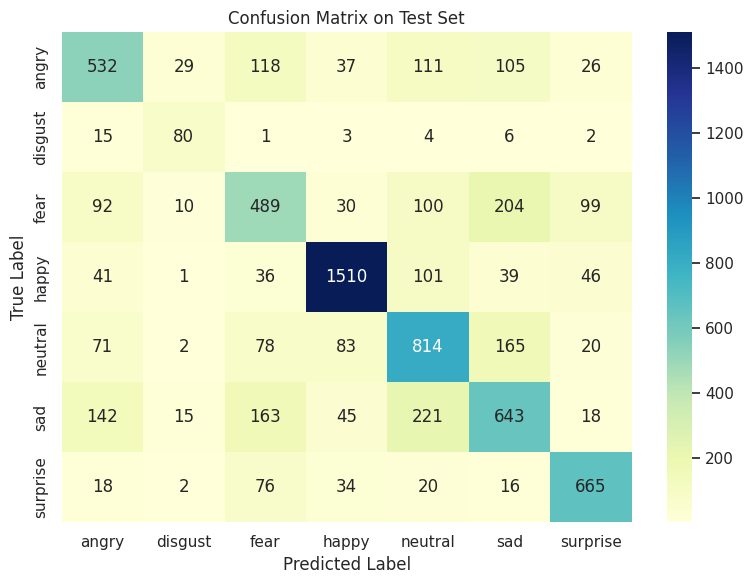

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get ground-truth labels
true_labels = validation_generator.classes

# Get predicted probabilities and labels
pred_probs = model.predict(validation_generator, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# Class names
class_names = list(train_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()


In [47]:
from tensorflow.keras.models import model_from_json

# Load architecture
with open('/kaggle/input/1/tensorflow2/default/1/model_architecture.json', 'r') as json_file:
    model = model_from_json(json_file.read())

# Load weights
model.load_weights('/kaggle/input/1/tensorflow2/default/1/final_model_weights.weights.h5')


In [48]:
!rm -f res10_300x300_ssd_iter_140000.caffemodel deploy.prototxt

!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-04-12 17:56:51--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.001s  

2025-04-12 17:56:51 (48.5 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-04-12 17:56:51--  https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_s

In [49]:
from tensorflow.keras.models import model_from_json

# Load model architecture
with open("/kaggle/input/1/tensorflow2/default/1/model_architecture.json", "r") as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)

# Load weights
model.load_weights("/kaggle/input/1/tensorflow2/default/1/final_model_weights.weights.h5")

print("Model architecture and weights loaded successfully!")


Model architecture and weights loaded successfully!


# Important Libraries and Open CV for Face Detection

In [50]:
import urllib.request
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

def _predict_dnn_from_url(image_url):
    # Download image from URL to temp location
    temp_path = "/kaggle/working/temp_input.jpg"
    urllib.request.urlretrieve(image_url, temp_path)

    # Load OpenCV DNN face detector
    net = cv2.dnn.readNetFromCaffe(
        'deploy.prototxt',
        'res10_300x300_ssd_iter_140000.caffemodel'
    )

    image = cv2.imread(temp_path)
    if image is None:
        print("Failed to load downloaded image.")
        return
    (h, w) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    count = 0
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.3:
            count += 1
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            x1, y1 = max(0, x1), max(0, y1)

            face = image[y1:y2, x1:x2]
            if face.size == 0:
                continue
            face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face_resized = cv2.resize(face_gray, (224, 224)) / 255.0
            input_img = np.expand_dims(face_resized, axis=-1)
            input_img = np.expand_dims(input_img, axis=0)

            prediction = model.predict(input_img)
            maxindex = int(np.argmax(prediction))
            label = emotion_dict[maxindex]
            emoji = emojis[maxindex]

            text = f"{label} ({confidence*100:.1f}%) {emoji}"
            cv2.putText(image, text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    print("No of faces:", count)
    cv2_imshow(image)

    # Optional: cleanup
    os.remove(temp_path)


In [51]:
# Emotion labels (must match your model's class order)
emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# Optional emojis for each emotion
emojis = {
    0: "😠",
    1: "🤢",
    2: "😨",
    3: "😄",
    4: "😢",
    5: "😲",
    6: "😐"
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
No of faces: 1


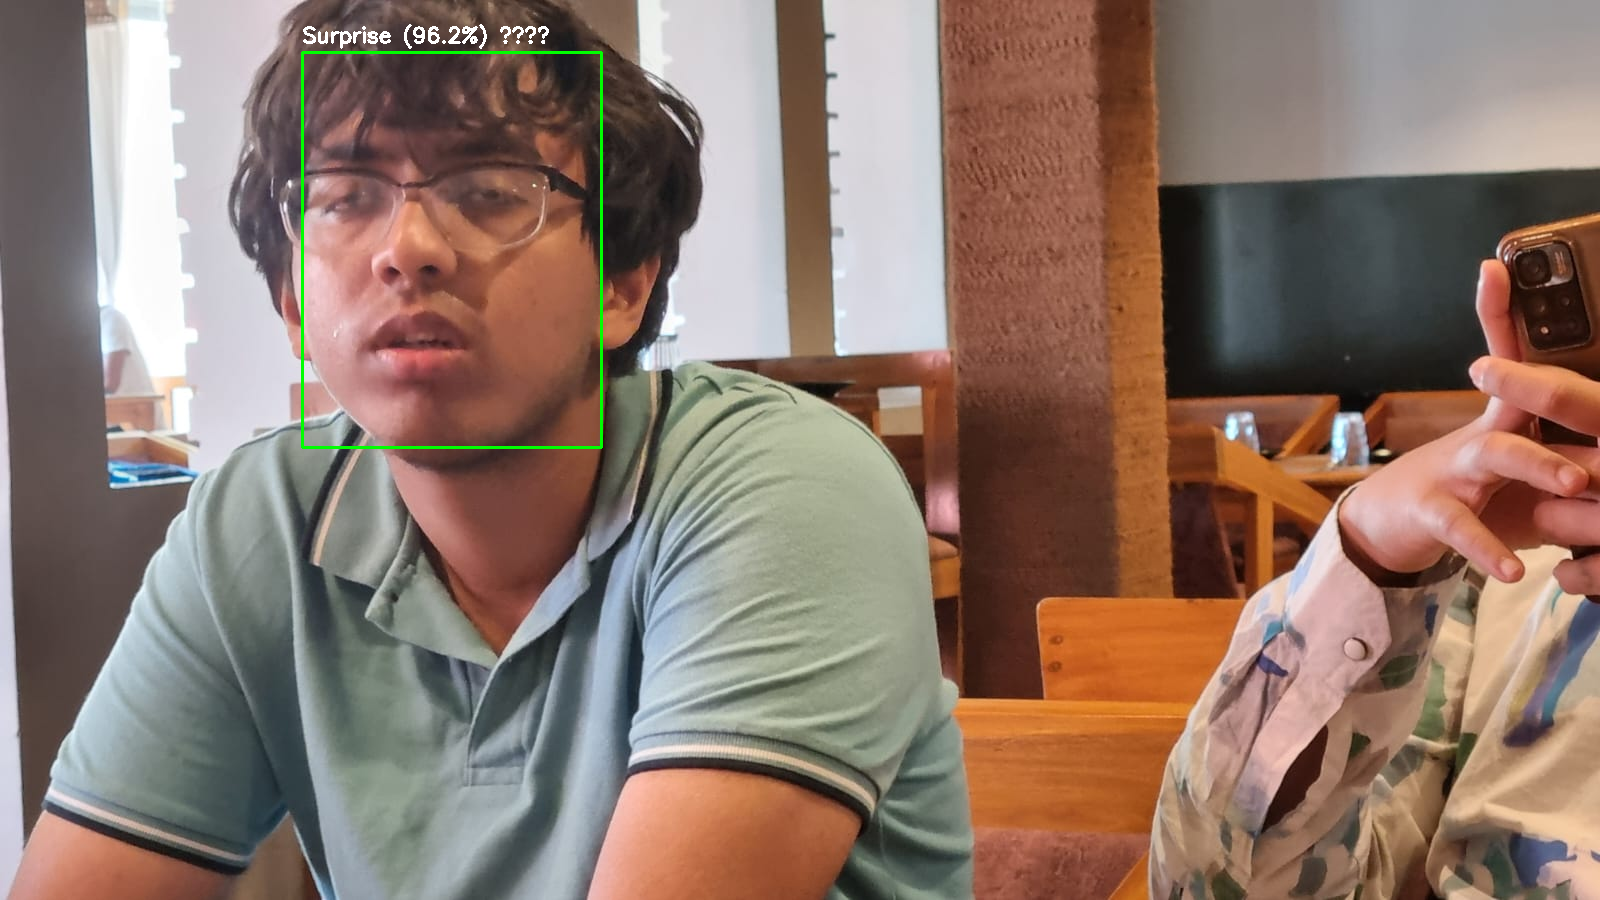

In [52]:
url = "https://media-hosting.imagekit.io/8551d0d5de704a04/WhatsApp%20Image%202025-04-12%20at%2012.20.02_402daadf.jpg?Expires=1839049330&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=ErUxeC6BTx2hMGkzMjgCsW7-PR2ynMLd2KtzGzZzodzSEZ0QGJ~UUsZ1MpGWCHgXUwrf4HEQfVpWIt2hnO2FD5aMMkVIDKClISra1uVaeD8gydeYUkor2ZWjNYMrQKYnf-U~fUxA3ZbrjgA8CLKxKVWywTpbvWKxjYSV3gef5nklf3S31~bQwPd8szXcPubAY~lyCQ0uCGYnzE9sR4815jjFRnyK0lYhskpPE~rST9Q48T1g8PqTWcWFcx9SdgwxbPP61OFad67FUiLGxZ7pFuIB4etKWXWpS1iOkyKID0jCCqlVy8E6hsryJvF2YyVfFHm8-Hnazkd6cQjOEjxeQg__"
_predict_dnn_from_url(url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
No of faces: 2


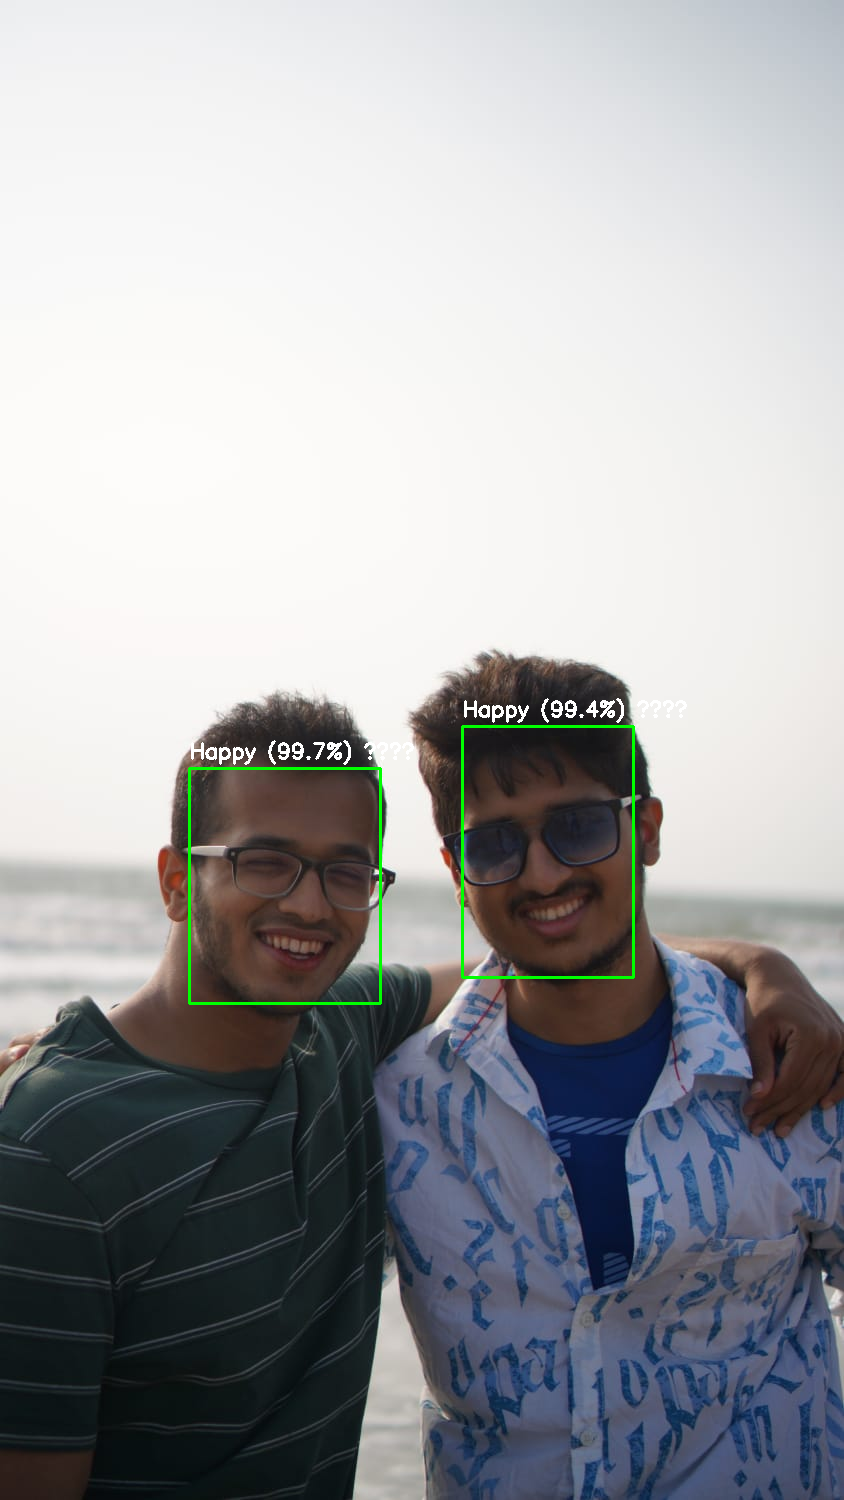

In [53]:
url = "https://media-hosting.imagekit.io/f48a83bebce34acb/WhatsApp%20Image%202024-06-25%20at%2018.43.08_7c6e4c3c.jpg?Expires=1839050601&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=FHi7qf1f~dKADbJRdcNYXy74MOMZsvJVpy09k4519iY2JrQkqSIeaKT0RJQ-s9QejLURM6nNS152TMwObNzIb9-ygNf~E9Rj6HsX2cyRAZ~mh-W0wIgDKSaJLt4KdwrqxyDmwAaVPTG07Ahbs~DZmoJTXAEjOvCvTyQmk3Dlv2C9rxhlwJ3GGeaVKd~6Z~kKh51Yz9JxqlOiNWmg56gv2O4ybjys~8YaF~M9hXdg0N28yW2FPgiZRBGr7e5rT0b2HSpOS6zCUYNEw9JbysTEZvX5eBlxX6EfUHb7Ge2x5MS28UQgGXRMVghN0Vaz6h-8OfzQaQSt3mzJWIfc6iYH-w__"
_predict_dnn_from_url(url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
No of faces: 1


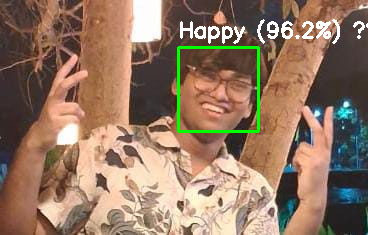

In [54]:
url = "https://media-hosting.imagekit.io/4e40f7afc6c4489b/WhatsApp%20Image%202025-04-12%20at%2012.24.20_813eea32.jpg?Expires=1839049328&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=KPT98x-TX1agz2AvM~v~QxMwuDsjeM2l9lTC~pdq22H6GkNleKfHTGoc35aJrLudStJUW4qnkLVJGBoDs3Hj2jQSoolZauf~vb19tHKvKcgXiOTgSsKAseUYO~rwuc6Eg9zlKLEtsTtKDN4--hf4VfaNAzBc6Rm1MWdPbW6AyJiHtuwtm7K7W3qGWJOBnDpj6blQTNisn88uC3SjIoeC4Bz76jQL6aVKUVTlbQyJsYVe21jSJYWHp7MExX24JnIsUEvB5M6LyiTn6ipyPAZZmsOLTuNWOvZqR2ghhRTOPkwuwKGi4p0pWwCaR65DFgCU5mk3aapErfKn~3Y1qjf2lQ__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/b7f1ad5245b44d43/_AMO6763[1].jpg?Expires=1839050802&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=VmD-a~NO6AHgXvWQPgyU1OfCkRu7VZ7Cz~J0hgJ5g-JT3xETKEgruT-383mKuKP4zHm3ZXqFPT~~ZW35SHDXoH7F73wtyv7n5t98XNeEF-fu9b2Stv0urzVP~yYgR3J-7yBTEA9buLu98IadhAJ6bVN1aXuRW4BGj4YoBa4hCHehBI1LAhw7smoLE1ztdXXs3fm7ghrpvHeU~H~UmSRPewI900NH3ExQT9R1fhqfhXD7rkHuSwjpENyjzNBsSEWVDhekCFdU1ATmqNrkgxkTQPDyWSeLL6SJNoO34~Np5ExkSN7llc6FNANQadbtLbCA0xZCDk~F7G1DYwtHZACepg__"
_predict_dnn_from_url(url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
No of faces: 4


In [ ]:
url = "https://media-hosting.imagekit.io/b7f1ad5245b44d43/_AMO6763[1].jpg?Expires=1839050802&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=VmD-a~NO6AHgXvWQPgyU1OfCkRu7VZ7Cz~J0hgJ5g-JT3xETKEgruT-383mKuKP4zHm3ZXqFPT~~ZW35SHDXoH7F73wtyv7n5t98XNeEF-fu9b2Stv0urzVP~yYgR3J-7yBTEA9buLu98IadhAJ6bVN1aXuRW4BGj4YoBa4hCHehBI1LAhw7smoLE1ztdXXs3fm7ghrpvHeU~H~UmSRPewI900NH3ExQT9R1fhqfhXD7rkHuSwjpENyjzNBsSEWVDhekCFdU1ATmqNrkgxkTQPDyWSeLL6SJNoO34~Np5ExkSN7llc6FNANQadbtLbCA0xZCDk~F7G1DYwtHZACepg__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/0a3d1aa309534c51/WhatsApp%20Image%202025-04-12%20at%2012.29.09_070f79c7.jpg?Expires=1839049320&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=r9lkduPitUWUQ-SCocjekqMDD7ZWt8C1FCY3n50mePM3k9sXpbWJkLM-BV4z6KpM7syBY0~fIxsg0eKugZSZbemIP~LMKW2AFlVfnU9P6z6mCFRl5T6dHSzTfXmqk7wymD5lJqHc7kMCI7iMnNtygnw9yqRf6YqZtnQ3gh5R5ENpfvNxccRVSD5B~hqoIS39EeLBEKgMRYJU4RTYnaHc2ESVtvT0oy1N66M3WOgTlv04zI~VIDkxKbhQAwSHHYH5dIMS2-CT6ebwhkCEPIDNi2nMv~uEl-acuON4G49E9sB7QENC3h7EHKXfrHI7-pSJqECXJp1wo3U-gq0YHOnQGQ__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/00197139ea5f4990/WhatsApp%20Image%202025-04-12%20at%2012.29.08_b9c1212d.jpg?Expires=1839049324&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=p8ARWiFB240KRFelgj-eN6-q69Z0vMaNgrGCw0sHgcAUixiu8XZC3FT489FYJMeO7dmHjQ-lYK-ickSowO~PwqRrBIoZzFfeabYzZ1jd5mi1NSEPoMnnpKCMtq4vrKzVAVEvkY5CD7eEorVRC7aLgsP2BFI9kVKFv7E7PnCxSRxC7TNj01xs~ECiz~pCpZ5sZBvk0X2~y8sdVPv6ZxGwonn0fY2LEvNbSK1WrL8KB-~GO6P11UKJ~6ivkZlOXJA-jbtsDuJF8noavHMWMNknbr4EelhzUeRn8Q~hggRtJMuKl8vVNg1gpRJaY-W-NVh3~yrfUAvISlf1XNhtJy7A3w__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/c3b766251ba14dd9/WhatsApp%20Image%202025-04-12%20at%2012.25.08_1334a6d6.jpg?Expires=1839049326&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=Gw-KKu8805zcvNNHibM5hPF88Koq50EF3CY7a7fJqk0T9D1eJ0G3yWZVIJe-bxWRhA-bifS6NVeSdrZEj0GdAmLd~Ysj-545ThZ1OZevhGzFGfmWsUkP6Y0mEP-Tzfndm5lA7gO8Cu4KXfefK4avztHC~QTerL2-E8RBjbBmE2yeL0HYeW0L78JExRrBhxijJigdqJHTSLwK5KTEX7rskQnUkwfYEGEUkFxTijw~aeUIORHsQzPM6BHixzCH-DSraX4YNtz8CXM9VauHLXuHbUxl9EstDV0gqBtfffLH~phOd6eSg0M2U7IJbI4IWy2faFUizpRGjczSB6L8zAhphA__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/2061397e700c4bae/WhatsApp%20Image%202025-04-12%20at%2012.29.08_5534de4a.jpg?Expires=1839049219&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=LhKuJjyBOBNXVgMGX8~8frnwH5CX~V2yucBIYjy06wHZO6ww5lCfKiN833CnfCPqvEC9omvroyFaea9Bv9EmyBCkARMAXAGK4Qd8TZkHlWu5PAUxvVd8IjpLvF6Kf8mYAkbq7ElLbU1xVnZHZz3G-sEaZcUCVdZfuTDVNQYStE0hX8~LI2e1859YdJKnrT-5zUTSqwTE7I6ki4f8FFfWfgIJX4fbFDYmA75mv1w1IQ3fJQzNMfbnjDLP4krHMr~tqnzQjaxAUY0UGxNlR9vQHO-rLoCKUIjEa0AK2lCEU48DI6fr4~S8R9kL4~NQkLogxHEEKvuHdjg-j1nYvw50EQ__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/74f1cc1785834ac4/WhatsApp%20Image%202025-04-02%20at%2004.10.44_78c524ee.jpg?Expires=1839050532&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=NsGKSl~b3WADsri-CRODEhvjnGMkjBmdDwkd~8Un6K5y2lTB4p3dtbVI4pZlEq3MtbbuOZvg0jlMaBr7dO97RLh22jTuTMAFx6NUIPfC3JCdULO~edc7AXcx8gwNDVgD0Xy6zRtICtrRL7TzJ88bd8TXwpY3EBR3g~JSNw3IvmN8ULke-LDSXQlUaBdljaa6Fd~MUr5rRbsErK0Djp0qvbxfFco1gdxJcSQMRgyiMNL68i07hFjNB6qdXPhqpvqyhv2o7-a5SRgjE3MAsfbTlWr~g0qWhKsOLPApV4tYgOAK30U2ojRrUc3DKkmUJ2UsKeFdwbUzjvooxLiOmrm3Eg__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/b4a6ce99b5324bda/WhatsApp%20Image%202025-04-12%20at%2012.49.03_94ed10b0.jpg?Expires=1839050349&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=uMCT2vRb6nmD7hi2889vYJJF8vGwU1zyTI5WTt1-j7KvKawIzOGwHxNB8O4dpkpZ5te9H6yp1vXgdegsqC7fgM6Epc9Hh8FCjqgvWanUHu4bFVyeUiLsDdybKTscWdlmDDAlNj38uxAa-93VpOJ~E8PHb~McrsBKxbcdEZRlvFHNlK5nxa3zM3XIwSrFDqI1SVVG7B3QuaGe~Rcwrh40LFkjEQKfytTsGalXHd6K3qxTq-eK~vFf8r1r434W0QVL6qY8bR63tbqJEa~ECV-GwoYuWRNGY2bxOVdt-Oo73k87DvKuvqlKr2W8MrPP5jwcL3CdCAC7bCblC13KVgAdtw__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/465f9aae9bc3465b/WhatsApp%20Image%202025-03-27%20at%2019.47.59_ccba722e.jpg?Expires=1839050398&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=ikFmMbRgNkqXsYuaxZH0YCrmfZ1348sAD036F6QbXO88LWElJXRcIHr0D64opBKijtMEKgM8aqplenglXAq568qwZA0O-dYKiidpz2BGNvacP8Qn~6hrAboWK8vqTbrnprK9nS4h5RiGeQ8U8Y616AcCkGGCvKYbNivd4DWJgyFrxtw9tOJ~GEK21ThraFKTVyt3Pt~i9BWs1RH1nYrkjDiR1WtcUO7ptekotDPB0jiUotVkeFqr2Ti93fl2~Is2u6-zlEG~zCrNRMOpHsvkf6deetF1rO8MQ3VBZ3lr9wKqWbyLl0R-4AUPxBjGtKr4b3pQ6WjI6xzcMAsDr9~COw__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/bf8ff5beb79f4a52/WhatsApp%20Image%202025-04-12%20at%2012.44.43_f2fe8559.jpg?Expires=1839050091&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=HbisTseQ9gvKKOP8bSHTvUUtyGy41xK5OzW1asGs~Bl0CgxdYochbxJsF5XEGlaE6M0PaXl6hw8aKoX2ODWmz3OvSXkfB3TR9SPC~SgOGiSUPcIXfsWwhdWRLhQYNo3fUPK9P8KSg7hM~9O0vbxwz6-XZYWyujfbho9gNFdTIYGmJ3crGNm4xJa-5YUxbb1H1BSnVRDN-MGjPtihv7NO9ByrnN4PxCnPXh3OjHPU396FN76QRb5MaVTxTBB1uoebnS9Bj0hq-Dt0X1e6j7P~SZiIQlZ~5NxNm~8OYOiakzdvSPLsnDoKoFnqOv4tmjJvtEh1yOtt8crutXX4zNQi0w__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/b7f1ad5245b44d43/_AMO6763[1].jpg?Expires=1839050802&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=VmD-a~NO6AHgXvWQPgyU1OfCkRu7VZ7Cz~J0hgJ5g-JT3xETKEgruT-383mKuKP4zHm3ZXqFPT~~ZW35SHDXoH7F73wtyv7n5t98XNeEF-fu9b2Stv0urzVP~yYgR3J-7yBTEA9buLu98IadhAJ6bVN1aXuRW4BGj4YoBa4hCHehBI1LAhw7smoLE1ztdXXs3fm7ghrpvHeU~H~UmSRPewI900NH3ExQT9R1fhqfhXD7rkHuSwjpENyjzNBsSEWVDhekCFdU1ATmqNrkgxkTQPDyWSeLL6SJNoO34~Np5ExkSN7llc6FNANQadbtLbCA0xZCDk~F7G1DYwtHZACepg__"
_predict_dnn_from_url(url)

In [ ]:
url = "https://media-hosting.imagekit.io/0fbc4a8db7c8406b/WhatsApp%20Image%202025-04-12%20at%2012.47.02_3b5179ca.jpg?Expires=1839050231&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=ZkYjcJoTC0VcMfRdUBlRReOnq3j39HIS5pOXQMm~GU~I6Iee4DCucZVPn57RpBsxVrQ9HiGAgmxFwoohu9Mumn6YaT2EVyIH0t5UlXcXFbihxSn6FSnw0ZPqsdljdfZSslozDToTgBzIHrH~8Rs1GGIOlLqo75pEP18nElb4qrd-liokNvQ64HRIZDExBU-ySG0Y3ReHQ1jKGQrbZ0VwhgUjzc5Ut762zxcWwiLrvuqY13avJ8Ix3zDNXWuE8Y0mzYjW3Ypr45dIn3EEMSDVCWQmRfqLps~ZfrHLgtERDeJaLQblhSd-S1QSwdQ40p8h9EB88~dgwIM-QrRMwaExgQ__"
_predict_dnn_from_url(url)